In [23]:
import torch
import torch.nn.functional as F

def gradient_loss(input_image, target_image):
    # Define the convolution kernels for gradient extraction
    C_G = torch.tensor([
        [[[-1, 0, 0], [0, 1, 0], [0, 0, 0]]],
        [[[0, -1, 0], [0, 1, 0], [0, 0, 0]]],
        [[[0, 0, -1], [0, 1, 0], [0, 0, 0]]],
        [[[0, 0, 0], [-1, 1, 0], [0, 0, 0]]],
        [[[0, 0, 0], [0, 1, -1], [0, 0, 0]]],
        [[[0, 0, 0], [0, 1, 0], [-1, 0, 0]]],
        [[[0, 0, 0], [0, 1, 0], [0, -1, 0]]],
        [[[0, 0, 0], [0, 1, 0], [0, 0, -1]]]
    ]).float()
    
    pixel_loss = torch.abs(input_image - target_image).mean()
    # Expand the convolution kernels for RGB channels
    C_G = C_G.expand(-1, 3, -1, -1)

    input_gradients = F.conv2d(input_image, C_G, padding=1)
    target_gradients = F.conv2d(target_image, C_G, padding=1)

    diff = torch.abs(input_gradients - target_gradients)

    # Sum all differences
    gradient_loss = torch.sum(diff, dim=1).mean()
    print(pixel_loss, gradient_loss)
    return pixel_loss + gradient_loss


# import torch
# import torch.nn.functional as F

# def gradient_loss(input_image, target_image):
#     # Define the convolution kernel for gradient extraction
#     C_G = torch.tensor([
#         [[-1, 0, 0], [0, 1, 0], [0, 0, 0]],
#         [[0, -1, 0], [0, 1, 0], [0, 0, 0]],
#         [[0, 0, -1], [0, 1, 0], [0, 0, 0]],
#         [[0, 0, 0], [-1, 1, 0], [0, 0, 0]],
#         [[0, 0, 0], [0, 1, -1], [0, 0, 0]],
#         [[0, 0, 0], [0, 1, 0], [-1, 0, 0]],
#         [[0, 0, 0], [0, 1, 0], [0, -1, 0]],
#         [[0, 0, 0], [0, 1, 0], [0, 0, -1]]
#     ]).unsqueeze(1).unsqueeze(2).float()

#     # Split input and target images into separate channels
#     input_channels = torch.split(input_image, 1, dim=1)
#     target_channels = torch.split(target_image, 1, dim=1)

#     # Compute the gradient loss for each channel
#     loss = 0.0
#     for input_channel, target_channel in zip(input_channels, target_channels):
#         # Perform convolution on the current channel
#         input_gradients = F.conv2d(input_channel, C_G, stride=1, padding=1)
#         target_gradients = F.conv2d(target_channel, C_G, stride=1, padding=1)

#         # Compute the pixel-wise absolute difference
#         diff = torch.abs(input_gradients - target_gradients)

#         # Accumulate the loss for the current channel
#         loss += torch.sum(diff)

#     return loss

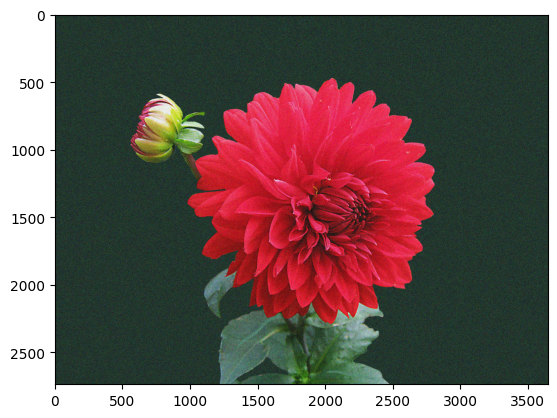

In [4]:
from skimage.io import imread
from skimage.util import img_as_float32
import matplotlib.pyplot as plt
import numpy as np

img1 = imread("image3_one.png")[:, :, :3]
img2 = imread("image3_two.png")[:, :, :3]

noise = np.random.normal(loc=0, scale=50, size=img2.shape)
noisy_img2 = np.clip(img2 + noise, 0, 255).astype(np.uint8)
img1 = img_as_float32(img1)
noisy_img2 = img_as_float32(noisy_img2)

plt.imshow(noisy_img2)

In [20]:
img1_tensor = torch.tensor(img1.transpose((2, 0, 1)), dtype=torch.float).unsqueeze(0)
noisy_img2_torch = torch.tensor(noisy_img2.transpose((2, 0, 1)), dtype=torch.float).unsqueeze(0)
noisy_img2_torch.requires_grad = True

In [21]:
# g_loss_dummy = gradient_loss()

In [24]:
gradient_loss(img1_tensor, noisy_img2_torch)

tensor(0.1292, grad_fn=<MeanBackward0>) tensor(2.4997, grad_fn=<MeanBackward0>)


tensor(2.6289, grad_fn=<AddBackward0>)

In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GLoss(nn.Module):
    def __init__(self):
        super(GLoss, self).__init__()
        self.gradient_kernel = nn.Parameter(torch.Tensor([
            [[-1, 0, 0], [0, 1, 0], [0, 0, 0]],
            [[0, -1, 0], [0, 1, 0], [0, 0, 0]],
            [[0, 0, -1], [0, 1, 0], [0, 0, 0]],
            [[0, 0, 0], [-1, 1, 0], [0, 0, 0]],
            [[0, 0, 0], [0, 1, -1], [0, 0, 0]],
            [[0, 0, 0], [0, 1, 0], [-1, 0, 0]],
            [[0, 0, 0], [0, 1, 0], [0, -1, 0]],
            [[0, 0, 0], [0, 1, 0], [0, 0, -1]]
        ]))

    def forward(self, I, I_hat):
        # Calculate pixel loss
        pixel_loss = torch.abs(I - I_hat).mean()

        # Calculate gradient feature maps
        I_grad = F.conv2d(I, self.gradient_kernel.unsqueeze(0), padding=1)
        I_hat_grad = F.conv2d(I_hat, self.gradient_kernel.unsqueeze(0), padding=1)

        # Calculate gradient loss
        gradient_loss = torch.abs(I_grad - I_hat_grad).mean()

        # Calculate downsampling losses
        avg_pool_loss = self.downsampling_loss(F.avg_pool2d(I, 2), F.avg_pool2d(I_hat, 2))
        max_pool_loss = self.downsampling_loss(F.max_pool2d(I, 2), F.max_pool2d(I_hat, 2))
        split_loss = self.downsampling_loss(self.splitting(I), self.splitting(I_hat))

        # Calculate the overall G-Loss
        g_loss = pixel_loss + gradient_loss + avg_pool_loss + max_pool_loss + split_loss

        return g_loss

    def downsampling_loss(self, I, I_hat):
        # Calculate gradient feature maps
        I_grad = F.conv2d(I, self.gradient_kernel.unsqueeze(0), padding=1)
        I_hat_grad = F.conv2d(I_hat, self.gradient_kernel.unsqueeze(0), padding=1)

        # Calculate gradient loss
        gradient_loss = torch.abs(I_grad - I_hat_grad).mean()

        return gradient_loss

    def splitting(self, I):
        batch_size, channels, height, width = I.size()
        I_split = I.view(batch_size, channels, height // 2, 2, width // 2, 2)
        I_split = I_split.permute(0, 1, 3, 5, 2, 4).contiguous()
        I_split = I_split.view(batch_size, channels * 4, height // 2, width // 2)

        return I_split


In [73]:
g_loss = GLoss()

In [74]:
g_loss(img1_tensor, noisy_img2_torch)

RuntimeError: Given groups=1, weight of size [1, 8, 3, 3], expected input[1, 3, 2736, 3648] to have 8 channels, but got 3 channels instead